<a href="https://colab.research.google.com/github/sami-sopas/Predict/blob/main/Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text(0.5, 0, 'Precio experimental')

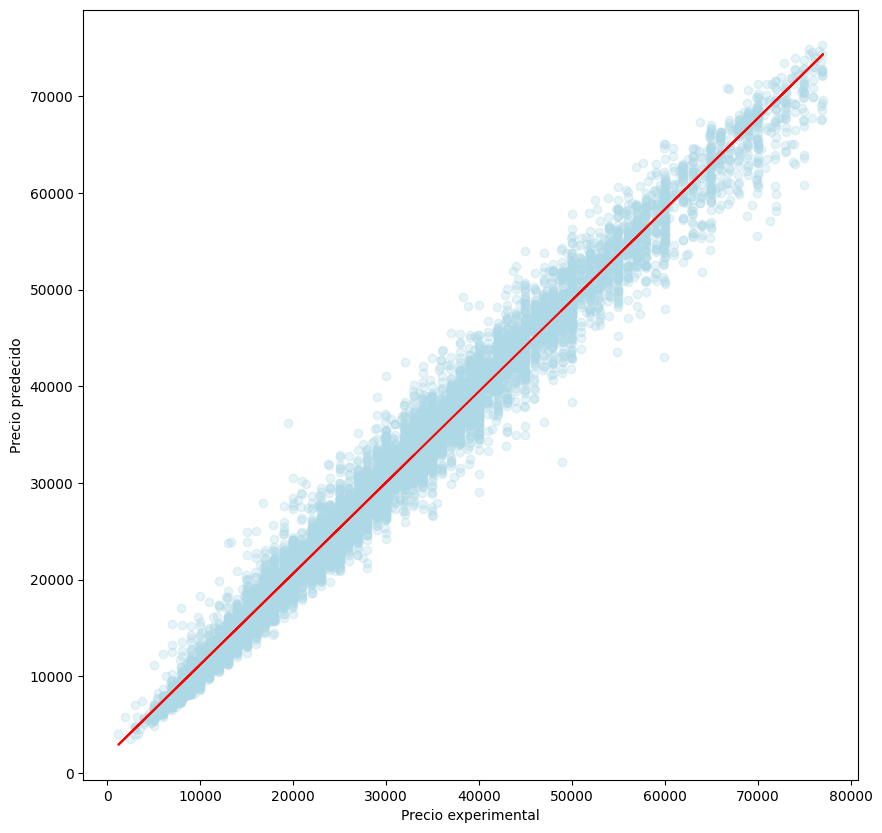

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("./sample_data/Australian Vehicle Prices.csv")

# Delete the row

df.drop(2391, axis=0, inplace=True)

# Converitr el año de float a int
df['Year'] = df['Year'].astype(int)

# Elimina filas donde 'Kilometres' es igual a '-' o '- / -'.
df = df.drop(df[df['Kilometres'] == '-'].index)
df = df.drop(df[df['Kilometres'] == '- / -'].index)

# Elimina filas donde 'Price' es igual a 'POA' (Price On Application).
df = df.drop(df[df['Price'] == 'POA'].index)
df.loc[df['Price'].isna()]

df.drop([10156, 11039], axis=0, inplace=True)

# Convertir datos de tipo objeto a int
df['Kilometres'] = pd.to_numeric(df['Kilometres'])
df['Price'] = pd.to_numeric(df['Price'])

df['Kilometres'] = df['Kilometres'].astype(int)
df['Price'] = df['Price'].astype(int)

# Eliminar columnas que no necesitaremos
df = df.drop(['Title','Car/Suv','Engine','ColourExtInt'], axis=1)

# Crear colummna Locacion, en donde estara el estado y la ciudad
df[['City','State']] = df['Location'].str.split(',', expand=True)

# Eliminar columnas 'Location' y'City'
df = df.drop(['Location','City'],axis=1)

# Crear columna 'Edad' para saber cuantos años tiene el carro

from datetime import date

date.today().year
df['Car_Age']=date.today().year-df['Year']

# Funcion que extrae números de columnas de cadena utilizando expresiones regulares.
def extract_number(data: 'pd.DataFrame',
                  col: 'str',
                  pattern: 'str') -> 'pd.Series':
    '''
    Extracts a number using the given regex pattern from the given data and col,
    converts the result to float, and returns the result as a pd.Series.
    '''
    return data[col].str.extract(pattern, expand=False).astype('float32')

# Aplicando la función a algunas columnas

df['FuelConsumption'] = extract_number(df, col='FuelConsumption', pattern=r'(\d+\.?\d*) L.*')
df['CylindersinEngine'] = extract_number(df, col='CylindersinEngine', pattern=r'(\d+) (?:cyl|L)')
df['Doors'] = extract_number(df, col='Doors', pattern=r'(\d+) Doors')
df['Seats'] = extract_number(df, col='Seats', pattern=r'(\d+) Seats')

# Removing outliers (Inter Quartile Range (IQR) approach)
Q1 = df['Kilometres'].quantile(0.25)
Q3 = df['Kilometres'].quantile(0.75)
IQR = Q3 - Q1

#print("25th quartile: ", Q1)
#print("75th quartile: ", Q3)
#print(IQR)

upper = Q3+1.5*IQR
#print("Upper Bound:", upper)

lower = Q1-1.5*IQR
#print("Lower Bound:", lower)

#We think one can make a judgement call here with respect to choosing a number for an upper bound. IQR approach has given us an upper bound of 305,000 kilometers.

# A total of 265 records are outside the upper bound

# New dataframe with outliers omitted

df2 = df[df['Kilometres'] < upper]

# Comparing before and after outlier removal

#plt.figure(figsize=(16,8))
#plt.subplot(2,2,1)
#sns.histplot(df['Price'], kde=True)

#plt.subplot(2,2,2)
#sns.boxplot(data = df['Price'])

#plt.subplot(2,2,3)
#sns.histplot(df2['Price'], kde=True)

#plt.subplot(2,2,4)
#sns.boxplot(data = df2['Price'])

Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

#print("25th quartile: ", Q1)
#print("75th quartile: ", Q3)
#print(IQR)

upper = Q3+1.5*IQR
#print("Upper Bound:", upper)

lower = Q1-1.5*IQR
#print("Lower Bound:", lower)

# New dataframe with outliers omitted

df2 = df2[df2['Price'] < upper]

#plt.figure(figsize=(16,8))
#plt.subplot(2,2,1)
#sns.histplot(df['Price'], kde=True)

#plt.subplot(2,2,2)
#sns.boxplot(data = df['Price'])

#plt.subplot(2,2,3)
#sns.histplot(df2['Price'], kde=True)

#plt.subplot(2,2,4)
#sns.boxplot(data = df2['Price'])
#

df2.dropna(inplace=True)
df2 = df2.drop(df2[df2['Transmission'] == '-'].index)

df2 = df2.drop(df2[df2['FuelType'] == '-'].index)

# Note: These are duplicates occuring after removal of certain columns like the ColorExtInt. These aren't duplicates at the
#       original dataframe.

# Eliminar duplicados

df2.drop_duplicates(keep=False, inplace=True)

#data encoding

df3 = df2

df3 = df3.drop(['Brand','Year','Model'], axis=1)

df3 = pd.get_dummies(df3)

#print("The shape of the encoded dataset: ", df3.shape)

y = df3['Price']

X = df3.drop(['Price'], axis =1)

# Contruccion del modelo

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenando el modelo

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)

# Aplicando el modelo para hacer la prediccion

y_rf_train_pred = rf.predict(X_train)

y_rf_test_pred = rf.predict(X_test)

# Evaluar el performance del modelo

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)
rf_results = pd.DataFrame(['Regresion Bosque Aleatorio', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Metodo','Entrenamiento MSE','Entrenamiento R2','Test MSE','Test R2']

rf_results

# graph

plt.figure(figsize=(10,10))
plt.scatter(x=y_train, y=y_rf_train_pred, c='#ADD8E6', alpha=0.3)

z= np.polyfit(y_train, y_rf_train_pred, 1)
p= np.poly1d(z)

plt.plot(y_train, p(y_train), '#FF0000')
plt.ylabel('Precio predecido')
plt.xlabel('Precio experimental')
